<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_06_07_survival_analysis_PyMC_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# Joint Modeling of Longitudinal and Survival Outcomes in PyMC

This tutorial demonstrates how to implement joint models for longitudinal and time-to-event data using PyMC. Joint models augment survival models by incorporating information from repeatedly measured outcomes over time, providing better survival estimates.

**Based on:** [Austin Rochford's blog post](https://austinrochford.com/posts/joint-long-surv.html)

**Reference:** Dimitris Rizopoulos's presentation *Joint Modeling of Longitudinal and Time-to-Event Data with Applications in R* and the `JMBayes2` R package documentation.

## Theory

### Survival Analysis

For the survival component, we use the proportional hazards model. The hazard function for the $i$-th subject with covariates $\mathbf{x}_i$ is:

$$\lambda(t\ |\ \mathbf{x}_i) = \lambda_0(t) \cdot \exp(\alpha \cdot \mathbf{x}_i),$$

where $\lambda_0(t)$ is the baseline hazard at time $t$ and $\alpha$ is a vector of regression coefficients.

We use the equivalent Poisson model to perform inference on these survival models.

### Joint Model

The goal is to improve survival models by incorporating information from longitudinal outcomes. We denote the longitudinal outcome for the $i$-th subject at time $t$ by $y_{i, t}$.

We assume independence of survival and longitudinal outcomes conditional on random effects. Specifically:

- Random effects model: $y_{i, t} \sim N(\mu_{i, t}, \sigma^2)$ with
  $$\mu_{i, t} = \beta \cdot \mathbf{x}_i + \gamma_{i, t},$$
  where $\gamma_{i, t}$ are random effects varying by subject and time.

- The longitudinal outcome influences survival through the random effects:
  $$\lambda(t\ |\ \mathbf{x}_i, \gamma_{i, t}) = \lambda_0(t) \cdot \exp(\alpha \cdot \mathbf{x}_i + \nu \cdot \gamma_{i, t}).$$

### Install Required Packages

In [ ]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', \
     'scikit-learn', 'scikit-survival', 'nutpie','lifelines',\
         'statsmodels', 'pymer4', 'PyMC', 'polars', 'numba']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
nutpie is already installed
lifelines is already installed
statsmodels is already installed
Installing pymer4...
Failed to install pymer4: No module named 'rpy2'
Error with package pymer4: No module named 'rpy2'
Installing PyMC...
Failed to install PyMC: No module named 'PyMC'
Error with package PyMC: No module named 'PyMC'
polars is already installed
numba is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ nutpie
✓ lifelines
✓ statsmodels
✗ pymer4
✗ PyMC
✓ polars
✓ numba


### Import Libraries

In [ ]:
%matplotlib inline

import arviz as az
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import nutpie
import polars as pl
import pymc as pm
from pytensor import tensor as pt
import seaborn as sns
from seaborn import objects as so

sns.set(color_codes=True)
plt.rcParams['figure.dpi'] = 120

### Load Data from GitHub URLs

In [ ]:
# Load data from GitHub
url_pbc2 = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/pbc2.csv"
url_pbc2_id = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/pbc2_id.csv"

pbc2 = pd.read_csv(url_pbc2)
pbc2_id = pd.read_csv(url_pbc2_id)

print("Longitudinal data shape:", pbc2.shape)
print("\nLongitudinal data columns:", pbc2.columns.tolist())
print("\nLongitudinal data head:")
print(pbc2.head())

print("\n" + "="*60)
print("\nBaseline data shape:", pbc2_id.shape)
print("\nBaseline data columns:", pbc2_id.columns.tolist())
print("\nBaseline data head:")
print(pbc2_id.head())

Longitudinal data shape: (1945, 20)

Longitudinal data columns: ['id', 'years', 'status', 'drug', 'age', 'sex', 'year', 'ascites', 'hepatomegaly', 'spiders', 'edema', 'serBilir', 'serChol', 'albumin', 'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic', 'status2']

Longitudinal data head:
   id      years status       drug        age     sex      year ascites  \
0   1   1.095170   dead  D-penicil  58.766838  female  0.000000     Yes   
1   1   1.095170   dead  D-penicil  58.766838  female  0.525682     Yes   
2   2  14.152338  alive  D-penicil  56.447815  female  0.000000      No   
3   2  14.152338  alive  D-penicil  56.447815  female  0.498302      No   
4   2  14.152338  alive  D-penicil  56.447815  female  0.999343      No   

  hepatomegaly spiders                    edema  serBilir  serChol  albumin  \
0          Yes     Yes  edema despite diuretics      14.5    261.0     2.60   
1          Yes     Yes  edema despite diuretics      21.3      NaN     2.94   
2          Ye

### Examine Data Structure

In [ ]:
# Examine the data structure
print("Longitudinal data info:")
print(pbc2.info())
print("\nBaseline data info:")
print(pbc2_id.info())

Longitudinal data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1945 entries, 0 to 1944
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1945 non-null   int64  
 1   years         1945 non-null   float64
 2   status        1945 non-null   object 
 3   drug          1945 non-null   object 
 4   age           1945 non-null   float64
 5   sex           1945 non-null   object 
 6   year          1945 non-null   float64
 7   ascites       1885 non-null   object 
 8   hepatomegaly  1884 non-null   object 
 9   spiders       1887 non-null   object 
 10  edema         1945 non-null   object 
 11  serBilir      1945 non-null   float64
 12  serChol       1124 non-null   float64
 13  albumin       1945 non-null   float64
 14  alkaline      1885 non-null   float64
 15  SGOT          1945 non-null   float64
 16  platelets     1872 non-null   float64
 17  prothrombin   1945 non-null   float64
 18  hist

### Identify Key Columns

In [ ]:
# Check for key columns needed for joint modeling
# We need: id, time variable, longitudinal outcome (e.g., bilirubin), treatment, survival status

# Identify time column (could be 'year', 'day', 'month', etc.)
time_cols = [col for col in pbc2.columns if any(x in col.lower() for x in ['year', 'day', 'month', 'time'])]
print("Potential time columns:", time_cols)

# Identify longitudinal outcome columns (biomarkers)
outcome_cols = [col for col in pbc2.columns if any(x in col.lower() for x in ['bili', 'bilirubin', 'serbili'])]
print("Potential longitudinal outcome columns:", outcome_cols)

# Identify treatment column
trt_cols = [col for col in pbc2.columns if any(x in col.lower() for x in ['drug', 'trt', 'treatment', 'rx'])]
print("Potential treatment columns:", trt_cols)

# Check survival status in baseline data
status_cols = [col for col in pbc2_id.columns if any(x in col.lower() for x in ['status', 'event', 'death'])]
print("Potential status columns:", status_cols)

Potential time columns: ['years', 'year']
Potential longitudinal outcome columns: ['serBilir']
Potential treatment columns: ['drug']
Potential status columns: ['status', 'status2']


### Prepare Longitudinal Data

In [ ]:
# Based on typical PBC2 dataset structure, let's prepare the data
# Assuming: id, year (time), serBilir (bilirubin), drug (treatment), status (survival)

# Prepare longitudinal dataframe
# Select relevant columns - adjust based on actual column names
if 'id' in pbc2.columns:
    df_long = pbc2.copy()
else:
    print("Warning: 'id' column not found. Please check column names.")

# Convert time to months if needed (assuming 'year' column exists)
if 'year' in df_long.columns:
    df_long['month'] = (df_long['year'] * 12).astype(int)
elif 'day' in df_long.columns:
    df_long['month'] = (df_long['day'] // 30).astype(int)
else:
    print("Warning: Time column not found. Please specify time column.")

# Identify bilirubin column
bili_col = None
for col in ['serBilir', 'bili', 'bilirubin', 'serBilir']:
    if col in df_long.columns:
        bili_col = col
        break

if bili_col is None:
    print("Warning: Bilirubin column not found. Available columns:", df_long.columns.tolist())

# Identify treatment column
trt_col = None
for col in ['drug', 'trt', 'treatment', 'rx']:
    if col in df_long.columns:
        trt_col = col
        break

print(f"Using bilirubin column: {bili_col}")
print(f"Using treatment column: {trt_col}")
print(f"Time range: {df_long['month'].min()} to {df_long['month'].max()} months")

Using bilirubin column: serBilir
Using treatment column: drug
Time range: 0 to 169 months


### Prepare Survival Data

In [ ]:
# Prepare survival data from baseline dataframe
# Merge with baseline to get survival information
if 'id' in pbc2_id.columns:
    # Get unique subjects with their survival information
    subj_df = pbc2_id.copy()

    # Identify status column
    status_col = None
    for col in ['status', 'status2', 'event']:
        if col in subj_df.columns:
            status_col = col
            break

    # Identify time-to-event column
    time_event_col = None
    for col in ['years', 'year', 'time', 'futime']:
        if col in subj_df.columns:
            time_event_col = col
            break

    print(f"Using status column: {status_col}")
    print(f"Using time-to-event column: {time_event_col}")

    # Convert time to months if needed
    if time_event_col and time_event_col in subj_df.columns:
        if 'year' in time_event_col.lower():
            subj_df['month_event'] = (subj_df[time_event_col] * 12).astype(int)
        else:
            subj_df['month_event'] = subj_df[time_event_col]

    # Create event indicator (1 = event, 0 = censored)
    if status_col:
        if subj_df[status_col].dtype == 'object':
            # If status is categorical (e.g., 'alive', 'dead', 'transplanted')
            subj_df['event'] = (subj_df[status_col] != 'alive').astype(int)
        else:
            # If status is numeric (0 = censored, 1+ = event)
            subj_df['event'] = (subj_df[status_col] > 0).astype(int)

    print(f"\nNumber of subjects: {len(subj_df)}")
    print(f"Number of events: {subj_df['event'].sum()}")
    print(f"Number censored: {(~subj_df['event'].astype(bool)).sum()}")
else:
    print("Warning: 'id' column not found in baseline data.")

Using status column: status
Using time-to-event column: years

Number of subjects: 312
Number of events: 169
Number censored: 143


### Prepare Data for Modeling

We need to:
1. Extract longitudinal outcomes (bilirubin)
2. Create subject indices
3. Prepare survival data (time-to-event and event indicators)
4. Set up time scales

### Extract Longitudinal Outcomes and Create Subject Indices

In [ ]:
# For this example, we'll assume the data structure matches the blog post
# Adjust column names as needed based on your actual data

# Try to find or assign the correct dataframe for longitudinal data
if 'df_long' in globals():
    _df_long = df_long
elif 'long_df' in globals():
    _df_long = long_df
else:
    raise NameError("Longitudinal dataframe (df_long or long_df) is not defined. Please define your data.")

# Also check that bili_col and trt_col exist
if 'bili_col' not in globals() or bili_col is None:
    raise NameError("The variable bili_col (bilirubin column name) is not defined. Please define bili_col.")
if 'trt_col' not in globals() or trt_col is None:
    raise NameError("The variable trt_col (treatment column name) is not defined. Please define trt_col.")

required_cols = ['id', 'month', bili_col, trt_col]
missing_cols = [col for col in required_cols if col not in _df_long.columns]
if missing_cols:
    raise ValueError(f"Missing the following required columns in longitudinal dataframe: {missing_cols}")

df = _df_long[required_cols].copy()
df.columns = ['id', 'month', 'bili', 'trt']

# Convert treatment to numeric (0/1)
if df['trt'].dtype == 'object':
    # If treatment is categorical, convert to numeric
    unique_trt = df['trt'].unique()
    # Set 0 to first category, 1 to second if present
    if len(unique_trt) > 1:
        df['trt'] = (df['trt'] == unique_trt[1]).astype(int)
    else:
        df['trt'] = (df['trt'] == unique_trt[0]).astype(int)
else:
    df['trt'] = df['trt'].astype(int)

# Remove missing values
df = df.dropna(subset=['bili', 'month'])

print(f"Longitudinal data shape: {df.shape}")
print(f"\nUnique subjects: {df['id'].nunique()}")
print(f"\nTreatment distribution:")
print(df.groupby('trt')['id'].nunique())
print(f"\nData head:")
print(df.head(10))

Longitudinal data shape: (1945, 4)

Unique subjects: 312

Treatment distribution:
trt
0    158
1    154
Name: id, dtype: int64

Data head:
   id  month  bili  trt
0   1      0  14.5    0
1   1      6  21.3    0
2   2      0   1.1    0
3   2      5   0.8    0
4   2     11   1.0    0
5   2     25   1.9    0
6   2     58   2.6    0
7   2     70   3.6    0
8   2     82   4.2    0
9   2     94   3.6    0


### Prepare Survival Data Arrays

In [ ]:
# Prepare survival data
# Get one row per subject with survival information
surv_cols = ['id', 'month_event', 'event']
if 'trt' in subj_df.columns:
    surv_cols.append('trt')
elif trt_col and trt_col in subj_df.columns:
    surv_cols.append(trt_col)

subj_df_model = subj_df[surv_cols].copy()
if 'trt' not in subj_df_model.columns and trt_col in subj_df.columns:
    subj_df_model['trt'] = subj_df[trt_col]
    if subj_df_model['trt'].dtype == 'object':
        unique_trt = subj_df_model['trt'].unique()
        subj_df_model['trt'] = (subj_df_model['trt'] == unique_trt[1] if len(unique_trt) > 1 else unique_trt[0]).astype(int)

print(f"Survival data shape: {subj_df_model.shape}")
print(f"\nSurvival data head:")
print(subj_df_model.head())

Survival data shape: (312, 5)

Survival data head:
   id  month_event  event       drug  trt
0   1           13      1  D-penicil    0
1   2          169      0  D-penicil    0
2   3           33      1  D-penicil    0
3   4           63      1  D-penicil    0
4   5           49      1    placebo    1


### Survival Model Only

First, let's fit a survival-only model to establish a baseline.

### Set Up Model Coordinates and Prepare Survival Arrays

In [ ]:
# Set up coordinates for PyMC model
t_max = max(df['month'].max(), subj_df_model['month_event'].max())
t = np.arange(t_max + 1)

coords = {
    "t": t,
    "drug": ["Placebo", "Treatment"]
}

# Prepare survival data in discrete time format
# Create exposure and event counts for each time period
n_subj = len(subj_df_model)
n_time = len(t)

# Create arrays for Poisson model
exposed = np.zeros((n_subj, n_time))
died_ = np.zeros((n_subj, n_time))

for i, row in subj_df_model.iterrows():
    idx = int(row['id']) - subj_df_model['id'].min()  # Convert to 0-indexed
    t_event = int(row['month_event'])
    event = int(row['event'])

    # Subjects are exposed up to their event/censoring time
    exposed[idx, :t_event+1] = 1

    # Event occurs at the event time (if event occurred)
    if event == 1 and t_event < n_time:
        died_[idx, t_event] = 1

# Treatment indicator
trt = subj_df_model['trt'].values

print(f"Exposed array shape: {exposed.shape}")
print(f"Died array shape: {died_.shape}")
print(f"Treatment array shape: {trt.shape}")

Exposed array shape: (312, 172)
Died array shape: (312, 172)
Treatment array shape: (312,)


### Define Helper Function for Noncentered Normal Priors

In [ ]:
# Helper function for noncentered normal priors
HALFNORMAL_SCALE = np.sqrt(2 / np.pi)

def noncentered_normal(name, dims=None, μ=0.0, σ=1.0):
    """Create a noncentered normal random variable."""
    Δ = pm.Normal(f"Δ_{name}", 0, 1, dims=dims)
    return pm.Deterministic(name, μ + σ * Δ, dims=dims)

### Define Survival-Only Model

In [ ]:
# Survival-only model
with pm.Model(coords=coords) as survival_model:
    # Baseline hazard (noncentered)
    log_λ0 = noncentered_normal("log_λ0", dims="t")
    λ0 = pt.exp(log_λ0)

    # Treatment effect
    α_trt = pm.Normal("α_trt", 0, 2.5)

    # Linear predictor
    η = pt.atleast_2d(α_trt * trt).T

    # Hazard rate
    λ = λ0 * pt.exp(η)

    # Poisson likelihood
    pm.Poisson("died", exposed * λ, observed=died_)

    # Survival function for average subject
    η_pred = pt.atleast_2d(α_trt * np.array([0, 1])).T
    λ_pred = λ0 * pt.exp(η_pred)
    Λ_pred = λ_pred.cumsum(axis=1)
    sf_pred = pm.Deterministic("sf_pred", pt.exp(-Λ_pred), dims=("drug", "t"))

print("Survival model created successfully!")

Survival model created successfully!


### Sample from Survival Model

In [ ]:
# Sample from survival model
SAMPLER_KWARGS = {
    "draws": 1000,
    "tune": 1000,
    "chains": 4,
    "cores": 4,
}

survival_trace = nutpie.sample(
    nutpie.compile_pymc_model(survival_model),
    target_accept=0.95,
    **SAMPLER_KWARGS
)

print("Sampling completed!")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.23,15
,2000,0,0.21,15
,2000,0,0.20,15
,2000,0,0.24,15


Sampling completed!


### Check Convergence Diagnostics

Max R-hat: 1.0045686375033678


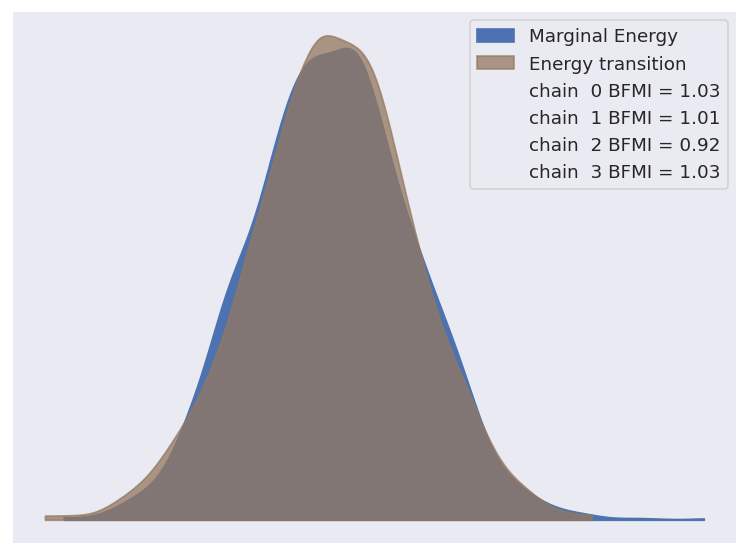

In [ ]:
# Check convergence
print(f"Max R-hat: {az.rhat(survival_trace).max().to_array().max().values}")
az.plot_energy(survival_trace);
plt.tight_layout()

### Plot Survival Model Results

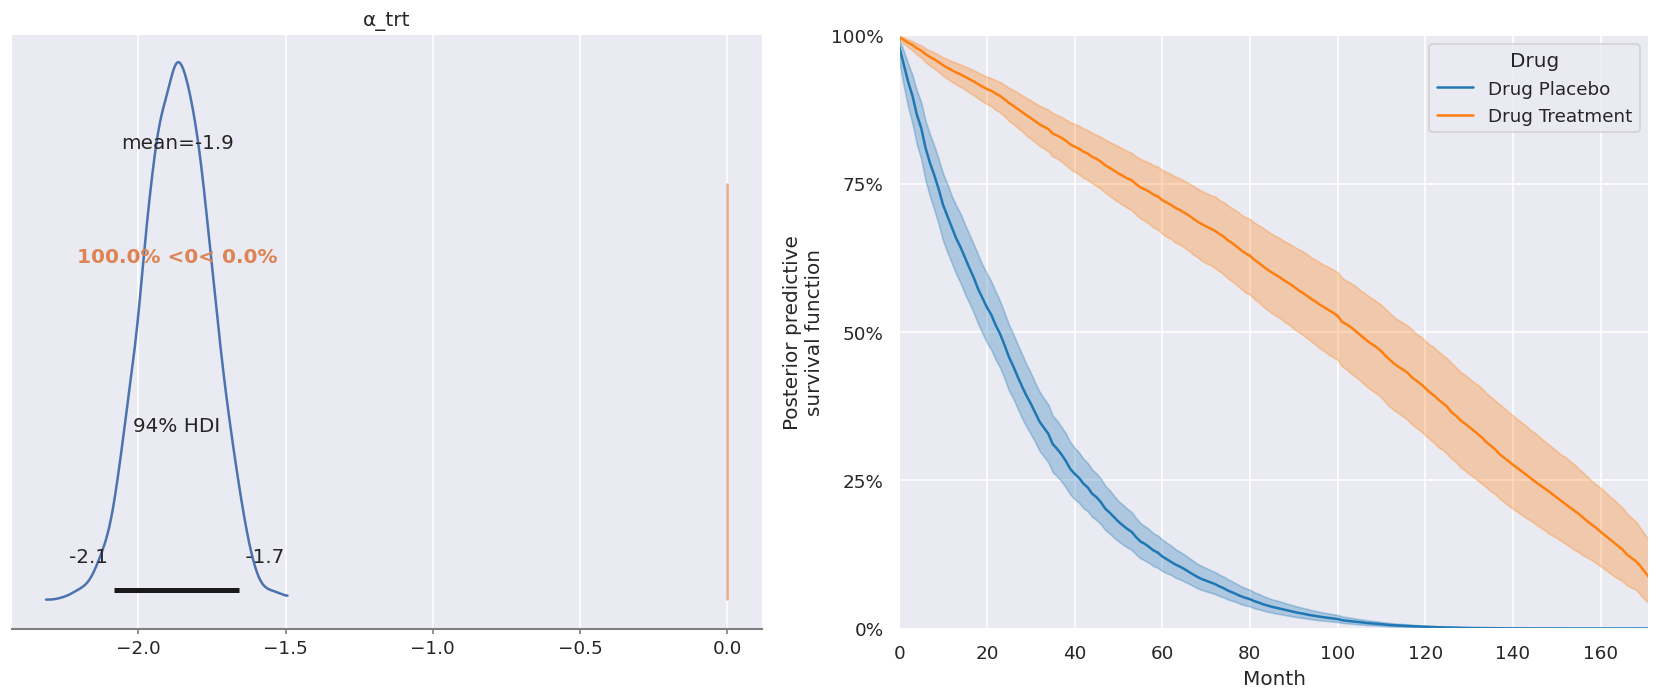

In [ ]:
# Plot results
fig, (α_ax, sf_ax) = plt.subplots(figsize=(14, 6), ncols=2)

# Treatment effect
az.plot_posterior(survival_trace, var_names="α_trt", ref_val=0, ax=α_ax)

# Survival function
# Fix credible interval calculation for pandas .agg with explicit names to avoid KeyError

sf_pred_df = survival_trace.posterior["sf_pred"].to_dataframe().reset_index()
# Expect columns: ["chain", "draw", "drug", "t", "sf_pred"]

# Calculate credible intervals with proper column names
summary_df = (
    sf_pred_df
    .groupby(['drug', 't'])['sf_pred']
    .agg(
        median='median',
        hdi_2_5=lambda x: np.percentile(x, 2.5),
        hdi_97_5=lambda x: np.percentile(x, 97.5),
    )
    .reset_index()
)

# Plot for each drug arm
drugs = summary_df['drug'].unique()
colors = plt.cm.tab10.colors
for idx, drug in enumerate(drugs):
    d = summary_df[summary_df['drug'] == drug]
    sf_ax.plot(d['t'], d['median'], label=f"Drug {drug}", color=colors[idx])
    sf_ax.fill_between(d['t'], d['hdi_2_5'], d['hdi_97_5'], color=colors[idx], alpha=0.3)

sf_ax.set_xlim(0, sf_pred_df['t'].max())
sf_ax.set_ylim(0, 1)
sf_ax.set_xlabel("Month")
sf_ax.set_ylabel("Posterior predictive\nsurvival function")
sf_ax.legend(title="Drug")
sf_ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
sf_ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

fig.tight_layout()

### Joint Model

Now we implement the joint model that incorporates longitudinal information.

### Prepare Longitudinal Data Arrays

In [ ]:
# Prepare longitudinal data arrays
bili = df["bili"].to_numpy()
i = (df["id"] - df["id"].min()).to_numpy()  # Subject index (0-indexed)

# Time scaler function
def make_time_scaler(t_max):
    def time_scaler(t):
        return t / t_max
    return time_scaler

time_scaler = make_time_scaler(df["month"].max())
t_visit = time_scaler(df["month"].to_numpy())

# Treatment indicator for longitudinal data
trt_long = df["trt"].to_numpy()

print(f"Bilirubin array shape: {bili.shape}")
print(f"Subject index shape: {i.shape}")
print(f"Visit time shape: {t_visit.shape}")
print(f"Unique subjects in longitudinal data: {len(np.unique(i))}")

Bilirubin array shape: (1945,)
Subject index shape: (1945,)
Visit time shape: (1945,)
Unique subjects in longitudinal data: 312


### Add Subject Coordinates to Model

In [ ]:
# Add subject ID to coordinates
coords["id"] = np.arange(len(subj_df_model))

print(f"Subject coordinates: {coords['id'][:10]}...")

Subject coordinates: [0 1 2 3 4 5 6 7 8 9]...


### Define Joint Model

In [ ]:
# Joint model
with pm.Model(coords=coords) as joint_model:
    # Longitudinal submodel
    # Random effects: intercept and time slope per subject
    γ0 = noncentered_normal("γ0", dims="id")
    γ_t = noncentered_normal("γ_t", dims="id")

    # Treatment effect on longitudinal outcome
    β_trt = pm.Normal("β_trt", 0, 2.5)

    # Mean of longitudinal outcome
    μ_bili = γ0[i] + γ_t[i] * t_visit + β_trt * trt_long[i]

    # Likelihood for longitudinal outcome (log-normal)
    σ_bili = pm.HalfNormal("σ_bili", 2.5 * HALFNORMAL_SCALE)
    pm.Normal("log_bili", μ_bili, σ_bili, observed=np.log(bili))

    # Survival submodel
    # Baseline hazard
    log_λ0 = noncentered_normal("log_λ0", dims="t")
    λ0 = pt.exp(log_λ0)

    # Association parameters
    α_trt = pm.Normal("α_trt", 0, 2.5)
    ν0 = pm.Normal("ν0", 0, 2.5)  # Association with random intercept
    ν_t = pm.Normal("ν_t", 0, 2.5)  # Association with random time slope

    # Linear predictor for survival
    # Need to evaluate random effects at survival times
    t_surv = time_scaler(coords["t"])

    η = sum([
        pt.atleast_2d(α_trt * trt + ν0 * γ0).T,
        ν_t * pt.outer(γ_t, pt.as_tensor(t_surv)),
    ])

    # Hazard rate
    λ = λ0 * pt.exp(η)

    # Poisson likelihood for survival
    pm.Poisson("died", exposed * λ, observed=died_)

    # Survival function for average subject
    η_pred = pt.add.outer(
        α_trt * np.array([0, 1]) + ν0 * γ0.mean(),
        ν_t * γ_t.mean() * t_surv,
    )
    λ_pred = λ0 * pt.exp(η_pred)
    Λ_pred = λ_pred.cumsum(axis=1)
    sf_pred = pm.Deterministic("sf_pred", pt.exp(-Λ_pred), dims=("drug", "t"))

print("Joint model created successfully!")

Joint model created successfully!


### Sample from Joint Model

In [ ]:
# Sample from joint model
joint_trace = nutpie.sample(
    nutpie.compile_pymc_model(joint_model),
    target_accept=0.95,
    **SAMPLER_KWARGS
)

print("Sampling completed!")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.14,31
,2000,0,0.14,31
,2000,0,0.14,31
,2000,0,0.10,63


Sampling completed!


### Check Convergence Diagnostics

Max R-hat: 1.5869323432838542


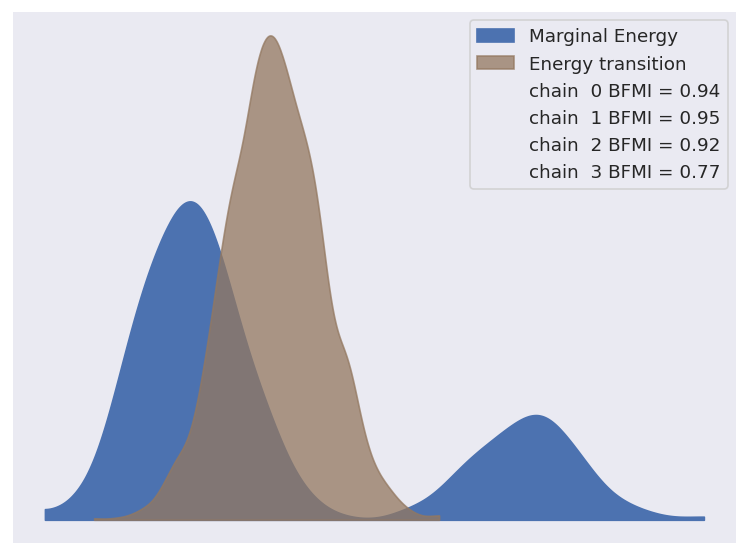

In [ ]:
# Check convergence
print(f"Max R-hat: {az.rhat(joint_trace).max().to_array().max().values}")
az.plot_energy(joint_trace);
plt.tight_layout()

### Plot Joint Model Results

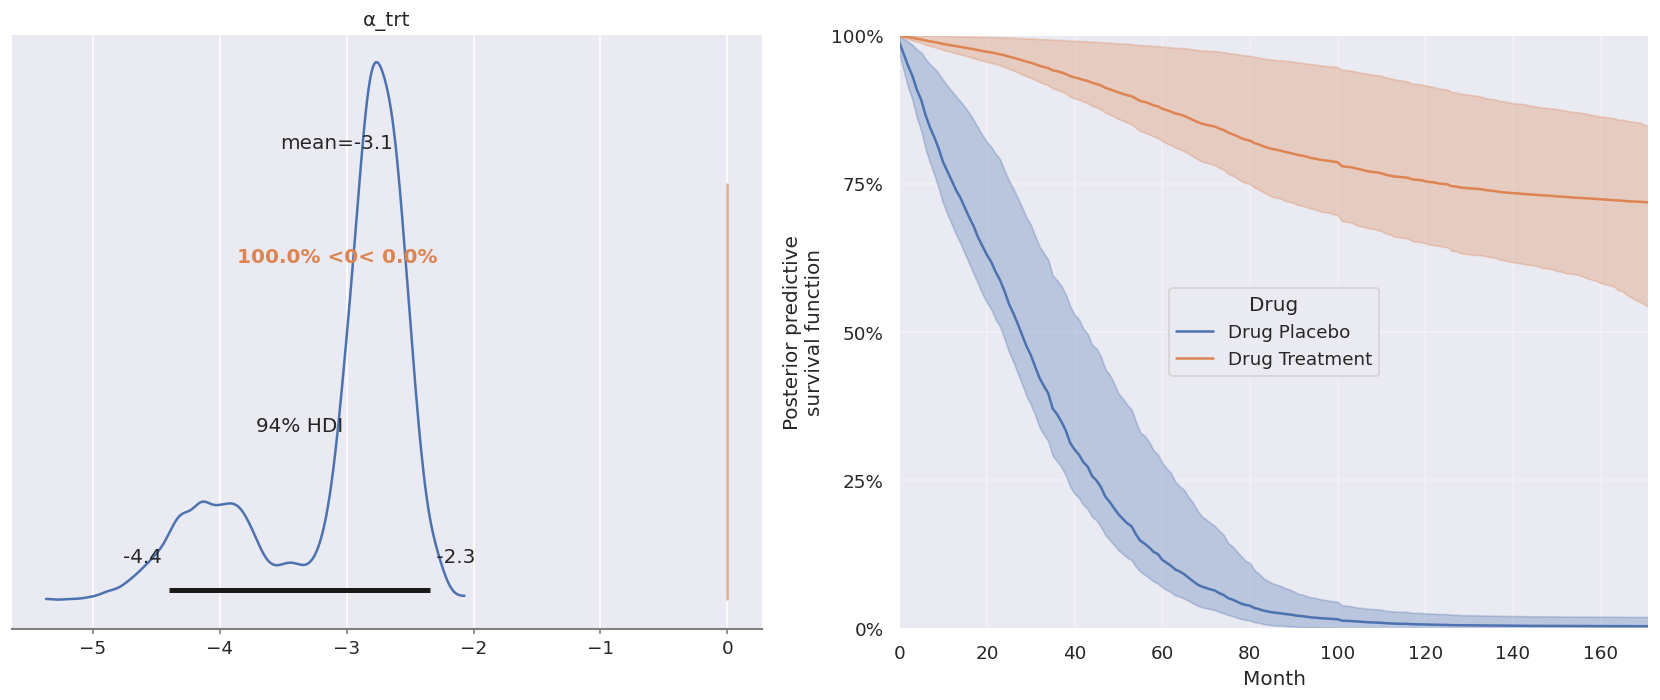

In [ ]:
# Plot joint model results
fig, (α_ax, sf_ax) = plt.subplots(figsize=(14, 6), ncols=2)

# Treatment effect
az.plot_posterior(joint_trace, var_names="α_trt", ref_val=0, ax=α_ax)

# Survival function
# Use matplotlib instead of seaborn.objects for credible interval bands

# Prepare data
sf_df = joint_trace.posterior["sf_pred"].to_dataframe().reset_index()
# "drug" coordinate, typically 0 for control, 1 for treatment
drugs = sf_df['drug'].unique()
colors = ["C0", "C1"]
t_vals = sf_df['t'].unique()

for i, drug_val in enumerate(drugs):
    sub = sf_df[sf_df['drug'] == drug_val]
    # Pivot: rows=samples, columns=t
    sub_pivot = sub.pivot(index=['chain', 'draw'], columns='t', values='sf_pred')
    samples = sub_pivot.values
    # Compute median and 95% HDI (quantiles)
    median = np.median(samples, axis=0)
    lower = np.quantile(samples, 0.025, axis=0)
    upper = np.quantile(samples, 0.975, axis=0)
    label = f'Drug {drug_val}'
    sf_ax.plot(t_vals, median, color=colors[i], label=label)
    sf_ax.fill_between(t_vals, lower, upper, color=colors[i], alpha=0.30)

sf_ax.set_xlim(0, t.max())
sf_ax.set_ylim(0, 1)
sf_ax.set_xlabel("Month")
sf_ax.set_ylabel("Posterior predictive\nsurvival function")
sf_ax.legend(title="Drug")
sf_ax.yaxis.set_major_locator(plt.MultipleLocator(0.25))
sf_ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))
sf_ax.grid(True, alpha=0.3)

fig.tight_layout()

### Examine Association Parameters

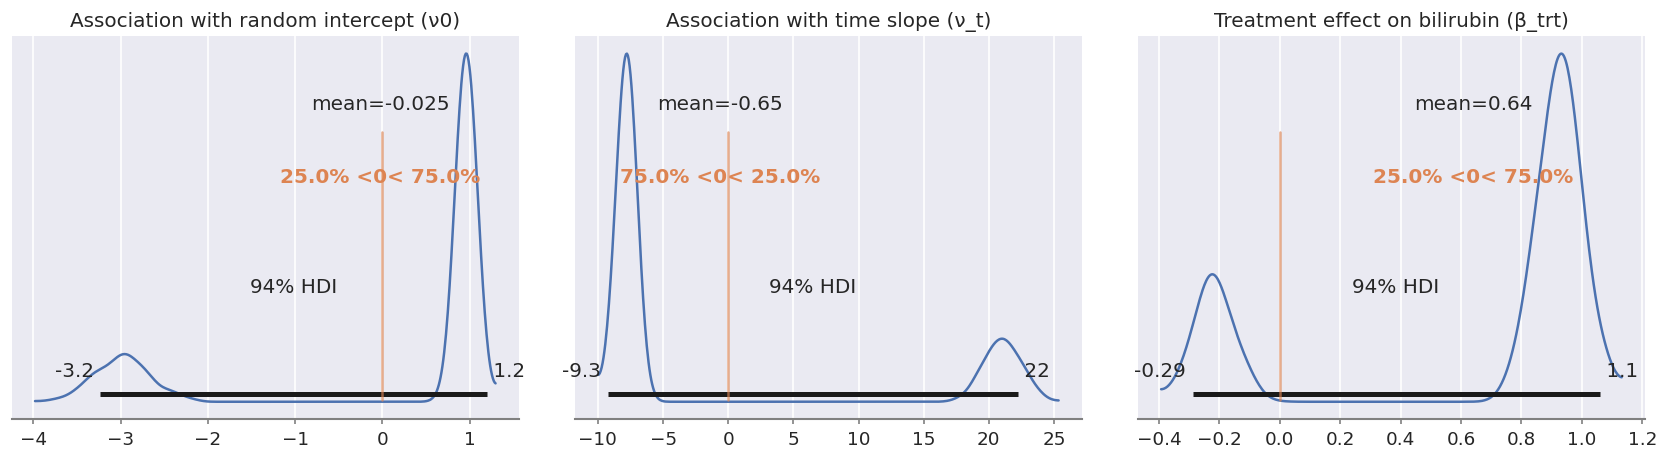

In [ ]:
# Compare association parameters
fig, axes = plt.subplots(figsize=(14, 4), ncols=3)

az.plot_posterior(joint_trace, var_names="ν0", ref_val=0, ax=axes[0])
axes[0].set_title("Association with random intercept (ν0)")

az.plot_posterior(joint_trace, var_names="ν_t", ref_val=0, ax=axes[1])
axes[1].set_title("Association with time slope (ν_t)")

az.plot_posterior(joint_trace, var_names="β_trt", ref_val=0, ax=axes[2])
axes[2].set_title("Treatment effect on bilirubin (β_trt)")

fig.tight_layout()

### Compare Treatment Effects Between Models

Survival-only model:
  Mean: -1.8685
  95% CI: [-2.0949, -1.6502]

Joint model:
  Mean: -3.0757
  95% CI: [-4.5330, -2.3802]


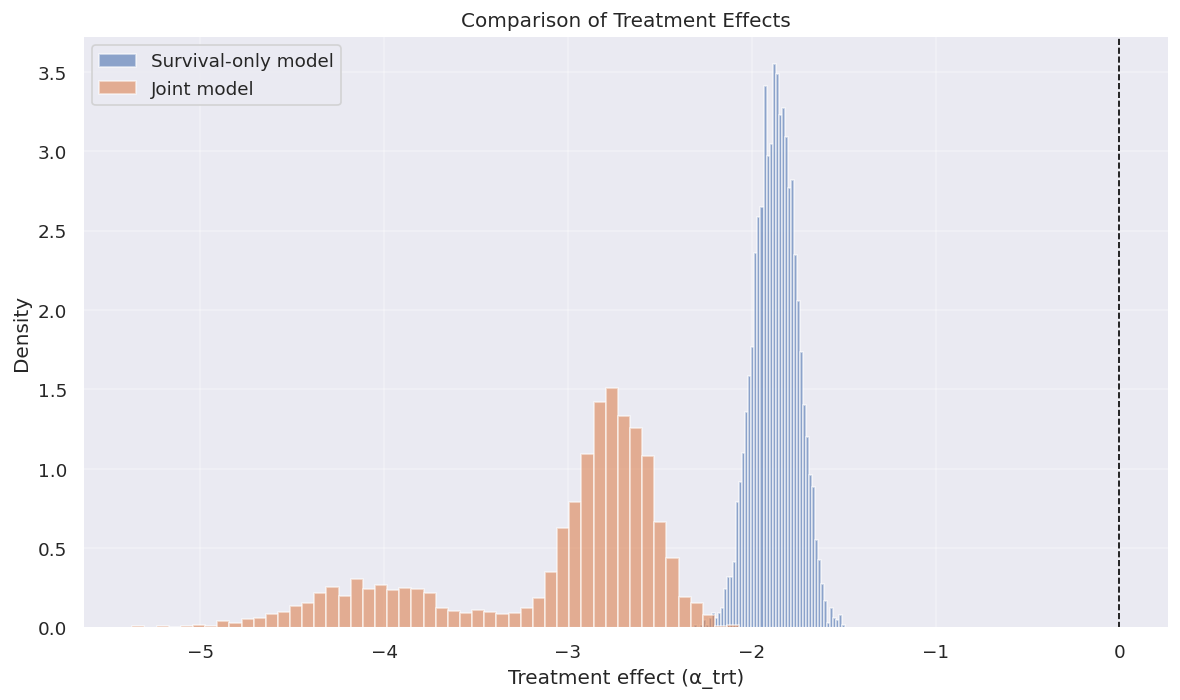

In [ ]:
# Compare treatment effects
fig, ax = plt.subplots(figsize=(10, 6))

# Extract posterior samples
survival_α = survival_trace.posterior["α_trt"].values.flatten()
joint_α = joint_trace.posterior["α_trt"].values.flatten()

# Plot distributions
ax.hist(survival_α, bins=50, alpha=0.6, label="Survival-only model", density=True)
ax.hist(joint_α, bins=50, alpha=0.6, label="Joint model", density=True)
ax.axvline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel("Treatment effect (α_trt)")
ax.set_ylabel("Density")
ax.set_title("Comparison of Treatment Effects")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()

# Print summary statistics
print("Survival-only model:")
print(f"  Mean: {survival_α.mean():.4f}")
print(f"  95% CI: [{np.percentile(survival_α, 2.5):.4f}, {np.percentile(survival_α, 97.5):.4f}]")

print("\nJoint model:")
print(f"  Mean: {joint_α.mean():.4f}")
print(f"  95% CI: [{np.percentile(joint_α, 2.5):.4f}, {np.percentile(joint_α, 97.5):.4f}]")

## Summary

This tutorial demonstrated:

1. **Survival-only model**: A baseline proportional hazards model using PyMC
2. **Joint model**: Incorporates longitudinal bilirubin measurements via random effects
3. **Comparison**: The joint model can provide different (often better) estimates of treatment effects by accounting for time-varying biomarker information

The joint model links the longitudinal and survival submodels through:
- Random intercepts (γ₀) affecting both bilirubin levels and survival
- Random time slopes (γ_t) affecting both bilirubin trajectories and survival
- Association parameters (ν₀, ν_t) quantifying these relationships

### Key Advantages of Joint Models:

- **Better survival predictions**: By incorporating biomarker trajectories
- **Handling of time-varying confounding**: Biomarkers can be both outcomes and confounders
- **More efficient use of data**: Uses all available longitudinal information

### Next Steps:

- Extend to include more covariates
- Add more longitudinal outcomes
- Implement different association structures
- Explore dynamic predictions

## References

- [Austin Rochford's Blog Post](https://austinrochford.com/posts/joint-long-surv.html)
- Rizopoulos, D. (2012). *Joint Models for Longitudinal and Time-to-Event Data: With Applications in R*. CRC Press.
- PyMC Documentation: https://www.pymc.io/
- ArviZ Documentation: https://www.arviz.org/